In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Attention, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import statsmodels.api as sm
from numpy.lib.stride_tricks import as_strided
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

#from keras.models import Sequential, Model
#from keras.layers import Conv1D, AveragePooling1D, Flatten, Activation, Conv2D, BatchNormalization, Input, Concatenate, Dense, MaxPooling1D, Dropout
#from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
def plot_signal_and_channels(signal, chans, zero=0, delta=5000):
    plt.figure(figsize=(20, 5))

    plt.subplot(2, 1, 1)
    plt.plot(signal[zero:zero+delta], label='Original Signal', color='blue')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(2, 1, 2) #data.index
    plt.plot(chans[zero:zero+delta], label='Channels', color='orange')
    plt.title('Channels')
    plt.legend()

In [6]:
file_path = 'data_extracted/my_shifted_train_data.csv'
data = pd.read_csv(file_path, header=None)[:]

y = data[2].astype(int)
X = data[1]

print(X.shape)
print(y.shape)

(129999,)
(129999,)


In [5]:
for i in range(X.shape[0]):
    if X[i] < 4.9: y[i] = 0

In [7]:
X_scaled = np.expand_dims(X, axis=1)
print(X_scaled.shape)
print(X_scaled[:10])

(129999, 1)
[[-0.34911427]
 [-0.24434906]
 [-0.1484023 ]
 [-0.06836197]
 [-0.01006586]
 [ 0.02239043]
 [ 0.027046  ]
 [ 0.0042152 ]
 [-0.04348767]
 [-0.11133264]]


In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_scaled)

print(X_scaled.shape)

(129999, 1)


In [9]:
X_scaled[0][:10]

array([0.37073724])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.squeeze(), y, test_size=0.2, shuffle=False)

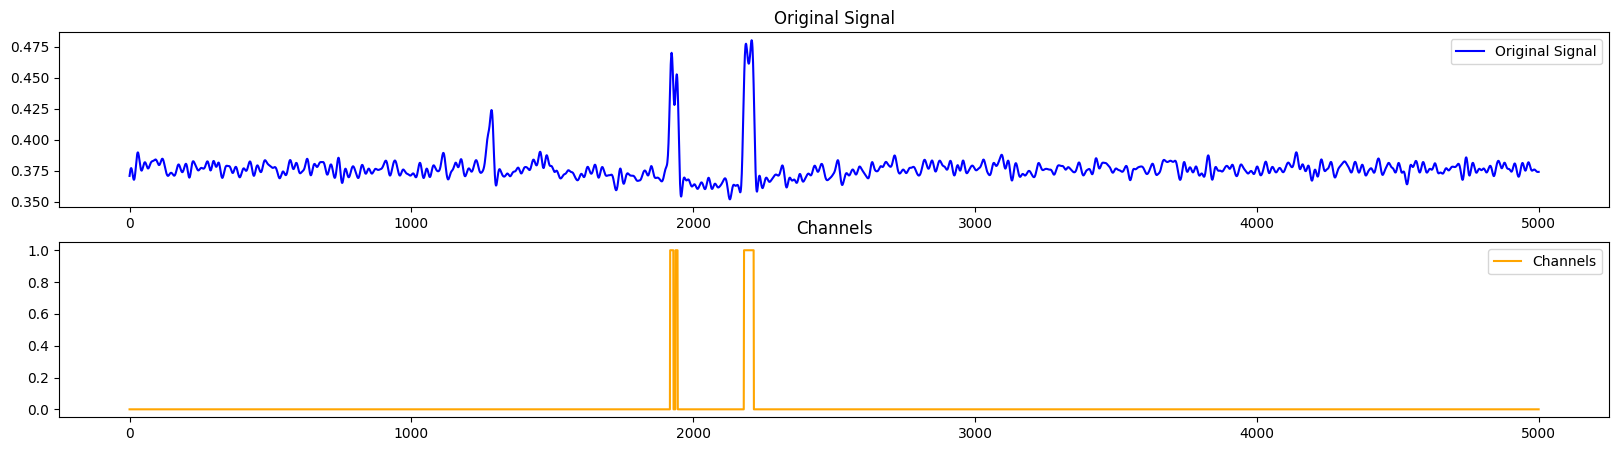

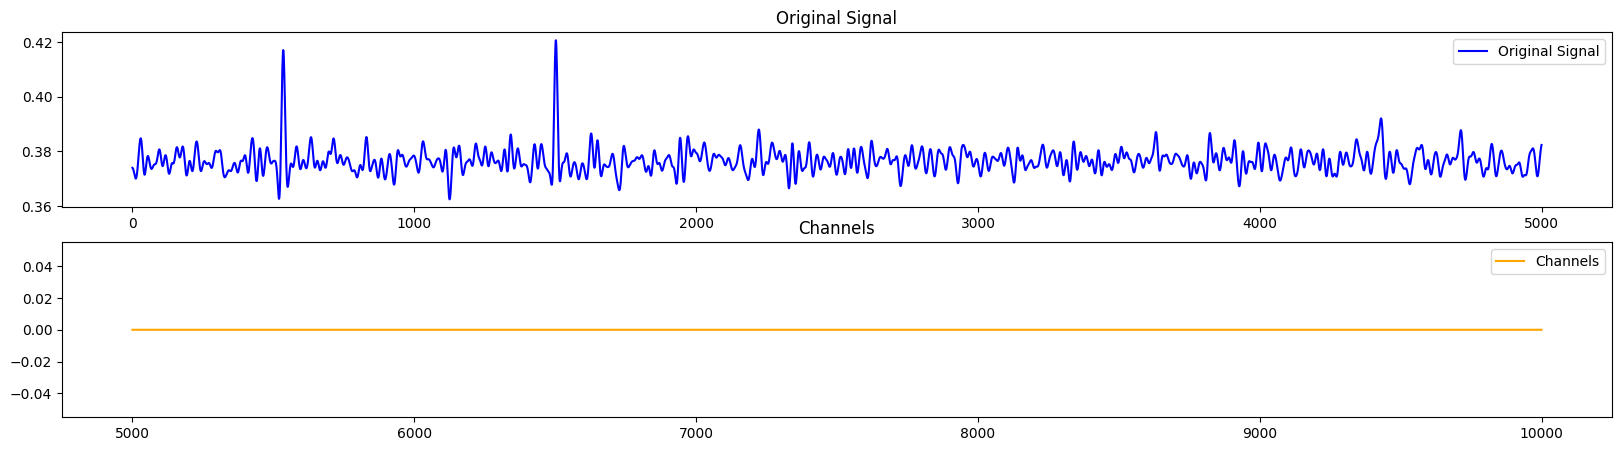

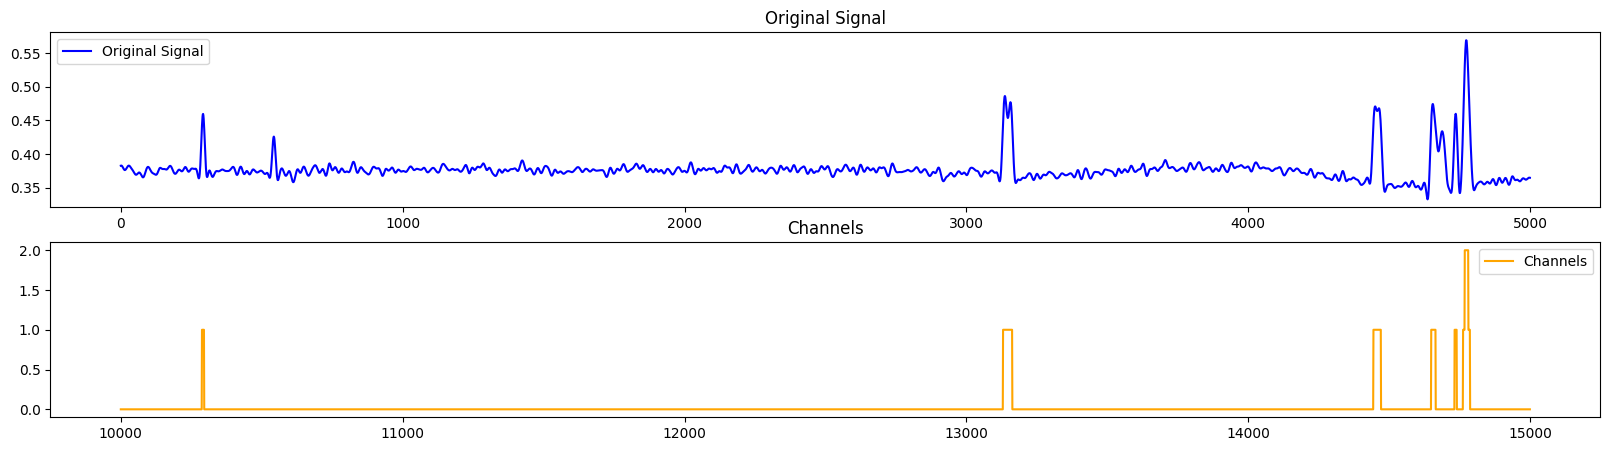

In [11]:


steps = 5000
for x in range(0,12000,steps):
    plt.figure(figsize=(20, 5))

    plt.subplot(2, 1, 1)
    plt.plot(X_train[x:x+steps], label='Original Signal', color='blue')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(2, 1, 2) #data.index
    plt.plot(y_train[x:x+steps], label='Channels', color='orange')
    plt.title('Channels')
    plt.legend()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed, Bidirectional, Add


def create_model2():
    # Define the encoder
    encoder_inputs = Input(shape=(None, 1))
    encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(128, activation="relu")(encoder)
    encoder_outputs, state_h, state_c = LSTM(64, return_state=True)(encoder)
    encoder_states = [state_h, state_c]

    # Define the decoder
    decoder_inputs = Input(shape=(None, 3))  # 3 classes: 0, 1, 2
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = Dropout(0.2)(decoder_outputs)
    decoder_dense = TimeDistributed(Dense(3, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_model3():
    # Define the encoder
    encoder_inputs = Input(shape=(None, 1))
    encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(128, activation="relu")(encoder)
    encoder = BatchNormalization()(encoder)
    encoder_outputs, state_h, state_c = LSTM(64, return_state=True, return_sequences=True)(encoder)
    encoder_states = [state_h, state_c]

    # Define the decoder
    decoder_inputs = Input(shape=(None, 3))  # 3 classes: 0, 1, 2
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = Dropout(0.2)(decoder_outputs)

    # Adding an attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])
    decoder_combined_context = Add()([decoder_outputs, attention])

    decoder_outputs = BatchNormalization()(decoder_combined_context)
    decoder_dense = TimeDistributed(Dense(3, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:

#TRAIN:
encoder_inputs = np.expand_dims(X_train, axis=0)  # Shape: (1, 50)
encoder_input_data = np.expand_dims(encoder_inputs, axis=-1) # Shape: (1, 50, 1)

start_token = 0  # Start token
decoder_inputs = np.insert(y_train[:-1], 0, start_token)  # Shift and add start token

num_classes = 3
decoder_input_data = np.eye(num_classes)[decoder_inputs]  # 50, 3)
decoder_input_data = np.expand_dims(decoder_input_data, axis=0)  # Shape: (1, 50, 3)

decoder_targets = np.eye(num_classes)[y_train]  # (batch_size=100, sequence_length=50, 3)
decoder_target_data = np.expand_dims(decoder_targets, axis=0)  # Shape: (1, 50, 3)

print("Encoder input shape:", encoder_input_data.shape)  # Should be (batch_size, sequence_length, 1)
print("Decoder input shape:", decoder_input_data.shape)  # Should be (batch_size, sequence_length, 3)
print("Decoder target shape:", decoder_target_data.shape)  # Should be (batch_size, sequence_length, 3)

#TEST:
encoder_inputs_test = np.expand_dims(X_test, axis=0)  # Shape: (1, 50)
encoder_input_data_test = np.expand_dims(encoder_inputs_test, axis=-1) # Shape: (1, 50, 1)

decoder_inputs_test = np.insert(y_test[:-1], 0, start_token)  # Shift and add start token

decoder_input_data_test = np.eye(num_classes)[decoder_inputs_test]  # 50, 3)
decoder_input_data_test = np.expand_dims(decoder_input_data_test, axis=0)  # Shape: (1, 50, 3)

decoder_targets_test = np.eye(num_classes)[y_test]  # (batch_size=100, sequence_length=50, 3)
decoder_target_data_test = np.expand_dims(decoder_targets_test, axis=0)  # Shape: (1, 50, 3)

Encoder input shape: (1, 103999, 1)
Decoder input shape: (1, 103999, 3)
Decoder target shape: (1, 103999, 3)


In [15]:
def reshape_to_batches(x, batch_size):
    x = x[:, :x.shape[1]-x.shape[1]%batch_size, :]

    num_batches = x.shape[1] // batch_size

    b_enc_inp = x.reshape((num_batches, batch_size, x.shape[2]))  # Shape: (10, 50, 1)
    print(b_enc_inp.shape)
    return b_enc_inp

In [16]:
encoder_input_data = reshape_to_batches(encoder_input_data, 100)
decoder_input_data = reshape_to_batches(decoder_input_data, 100)
decoder_input_data = decoder_input_data.astype(int)

decoder_target_data = reshape_to_batches(decoder_target_data, 100)
decoder_target_data = decoder_target_data.astype(int)

encoder_input_data_test = reshape_to_batches(encoder_input_data_test, 100)
decoder_input_data_test = reshape_to_batches(decoder_input_data_test, 100)
decoder_input_data_test = decoder_input_data_test.astype(int)

decoder_target_data_test = reshape_to_batches(decoder_target_data_test, 100)
decoder_target_data_test = decoder_target_data_test.astype(int)

(1039, 100, 1)
(1039, 100, 3)
(1039, 100, 3)
(260, 100, 1)
(260, 100, 3)
(260, 100, 3)


In [17]:
model = create_model2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, None, 128)            33792     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, None, 128)            0         ['bidirectional[0][0]']       
                                                                                                  
 dense (Dense)               (None, None, 128)            16512     ['dropout[0][0]']         

In [18]:

class_weights = {0: 1, 1: 2, 2: 2}
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=50, epochs=200, class_weight=class_weights)

Epoch 1/200
21/21 [==============================] - 7s 108ms/step - loss: 0.4513 - accuracy: 0.9886
Epoch 2/200
21/21 [==============================] - 2s 99ms/step - loss: 0.0763 - accuracy: 0.9935
Epoch 3/200
21/21 [==============================] - 2s 101ms/step - loss: 0.0617 - accuracy: 0.9935
Epoch 4/200
21/21 [==============================] - 2s 100ms/step - loss: 0.0516 - accuracy: 0.9937
Epoch 5/200
21/21 [==============================] - 2s 100ms/step - loss: 0.0412 - accuracy: 0.9945
Epoch 6/200
21/21 [==============================] - 2s 102ms/step - loss: 0.0359 - accuracy: 0.9948
Epoch 7/200
21/21 [==============================] - 2s 103ms/step - loss: 0.0321 - accuracy: 0.9952
Epoch 8/200
21/21 [==============================] - 2s 102ms/step - loss: 0.0294 - accuracy: 0.9957
Epoch 9/200
21/21 [==============================] - 2s 101ms/step - loss: 0.0258 - accuracy: 0.9960
Epoch 10/200
21/21 [==============================] - 2s 100ms/step - loss: 0.0244 - accurac

9/9 [==============================] - 0s 25ms/step - loss: 0.0190 - accuracy: 0.9955
Test Loss: [0.018980519846081734, 0.9954615235328674]
9/9 [==============================] - 0s 21ms/step
(26000,)
(26000,)


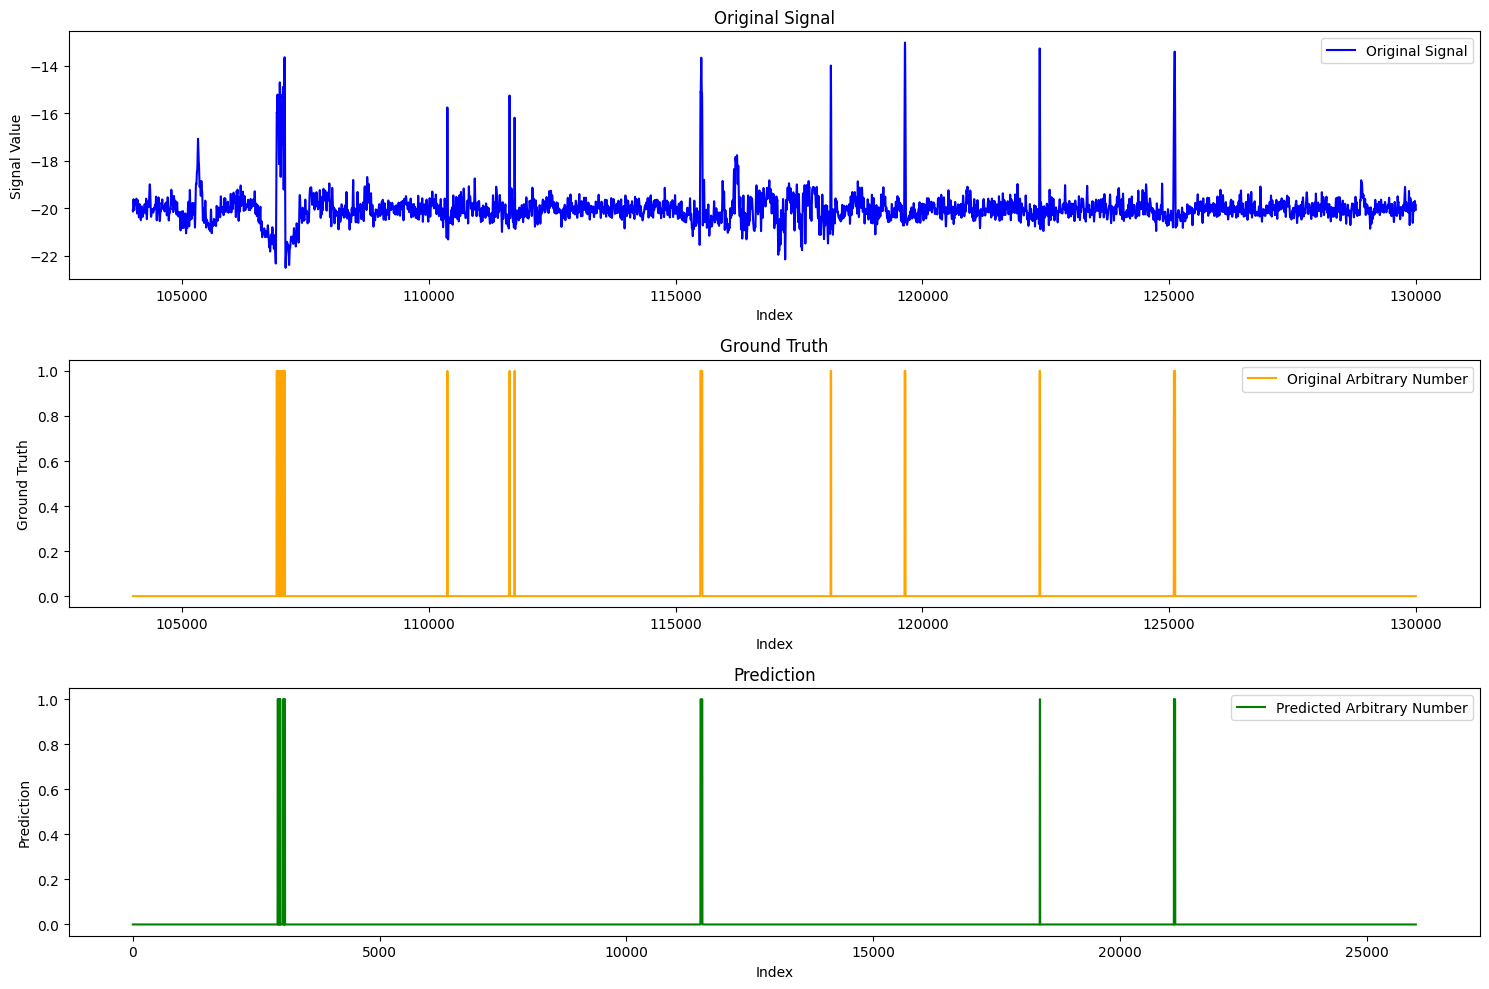

In [23]:
loss = model.evaluate([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test)
print(f'Test Loss: {loss}')

predictions = model.predict([encoder_input_data_test, decoder_input_data_test])
predicted_classes = np.argmax(predictions, axis=-1)

reshaped_data = predicted_classes.reshape(-1)
print(y_test.shape)
print(reshaped_data.shape)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test, label='Original Arbitrary Number', color='orange')
plt.title('Ground Truth')
plt.xlabel('Index')
plt.ylabel('Ground Truth')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Prediction')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
def decode_sequence(model, input_seq):
    # Get the number of batches and sequence length
    batches = input_seq.shape[0]
    seq_len = input_seq.shape[1]

    # Initialize the target sequence with the start token
    target_seq = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
    target_seq[:, 0, 0] = 1  # Start token (class 0)

    # Initialize the decoded sequence
    decoded_sequence = np.zeros((batches, seq_len))  # Shape: (batches, seq_len)

    # Iterate over each timestep
    for i in range(seq_len):
        print(i)

        # Slice the input sequence up to the current timestep
        inp = input_seq[:, :i+1, :]  # Shape: (batches, i+1, 1)

        # Perform prediction
        res = model.predict([inp, target_seq])  # Shape: (batches, i+1, 3)

        # Get the predicted class for the last timestep
        predicted_classes = np.argmax(res[:, -1, :], axis=-1)  # Shape: (batches,)

        # Update the decoded sequence
        decoded_sequence[:, i] = predicted_classes

        # Prepare the next target sequence
        if i < seq_len - 1:
            new_dec = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
            new_dec[np.arange(batches), 0, predicted_classes] = 1
            target_seq = np.concatenate([target_seq, new_dec], axis=1)

    return decoded_sequence

jopa = np.expand_dims(X_test[2500:3700], axis=0)
jopa = np.expand_dims(jopa, axis=-1)
print(jopa.shape)

jopa = decode_sequence(model, jopa)

print(jopa.shape)

(1, 1200, 1)
0
1/1 [==============================] - 1s 1s/step
1
1/1 [==============================] - 1s 933ms/step
2
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 14ms/step
6
1/1 [==============================] - 0s 15ms/step
7
1/1 [==============================] - 0s 14ms/step
8
1/1 [==============================] - 0s 14ms/step
9
1/1 [==============================] - 0s 17ms/step
10
1/1 [==============================] - 0s 15ms/step
11
1/1 [==============================] - 0s 18ms/step
12
1/1 [==============================] - 0s 17ms/step
13
1/1 [==============================] - 0s 16ms/step
14
1/1 [==============================] - 0s 16ms/step
15
1/1 [==============================] - 0s 17ms/step
16
1/1 [==============================] - 0s 17ms/step
17
1/1 [==============================] - 0s 16ms/step
18
1/1 [

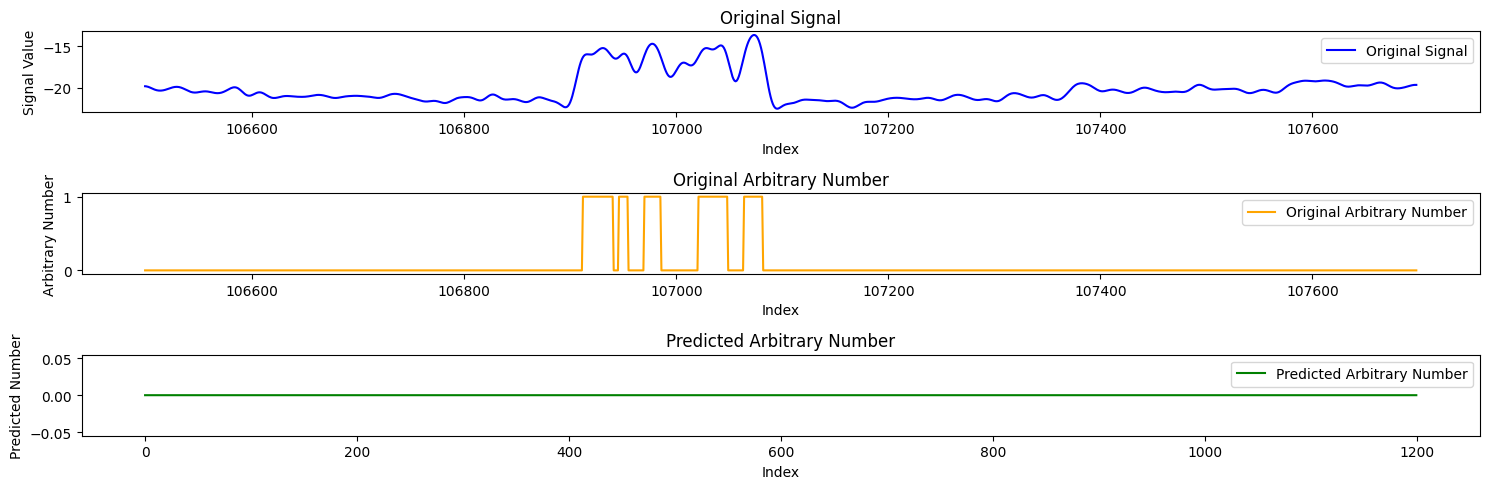

In [25]:
#predicted_classes = np.argmax(jopa, axis=-1)

reshaped_data = jopa.reshape(-1)


plt.figure(figsize=(15, 5))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test[2500:3700], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test[2500:3700], label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()